## Find Closet Stable Pose using Brute Force Method
* This notebook provides an pipeline of how to find the closest stable pose $T_\text{part}^\text{tag}(x, y, z, \alpha, \beta, \gamma)$ to a given pose estimate $\widehat{T}_\text{part}^\text{tag}$. 
* Brute Force Method: Find the stable pose that is closest to the given estimate. The distance metric here is the **Augular Difference** between two orientation representaions.

<img src="./11_23_image_dataset/stable_pose_parametrization.jpg" width="800">

### 1 Example with make-up Estimate for Insert Mold
##### Step1: construct a list of stable poses(orientation) represented by Rotation matrices

In [333]:
from scipy.spatial.transform import Rotation
import numpy as np
import matplotlib.pyplot as plt

In [334]:
# these two lists should be element-aligned. 
# e.g. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.array([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

def construct_R_sta_list(alphas):
    beta = 0
    # decretize gama at step of 1 degree
    gamas = np.arange(0, 360, 1)
    stable_poses_R = []
    for alpha in alphas:
        for gama in gamas:
            R = Rotation.from_euler('xyz', [alpha, beta, gama], degrees=True)
            stable_poses_R.append(R.as_matrix())
    return stable_poses_R

stable_poses_R = construct_R_sta_list(alphas_insertmold)
len(stable_poses_R)

1440

##### Step2: Find the closest three stable poses by iteratively computing the angular difference

In [335]:
R_est = Rotation.from_euler('xyz', np.radians([15, 5, 145])).as_matrix()

def angular_R_diff(R1, R2):
    R_diff = R1.T @ R2
    trace = np.trace(R_diff)
    angular_distance = np.rad2deg(np.arccos((trace - 1.) / 2.))
    return angular_distance

def find_top3_stable_poses(stable_poses_R, R_est, isPrint = True):
    angular_diffs = []
    for R_sp in stable_poses_R:
        angular_diffs.append(angular_R_diff(R_sp, R_est))

    # Get indices of the top three smallest angular differences
    top3_indices = np.argsort(angular_diffs)[:3]
    # Extract the corresponding rotation matrices
    top3_stable_poses_diff = [angular_diffs[i] for i in top3_indices]
    top3_stable_poses_R = [stable_poses_R[i] for i in top3_indices]

    if(isPrint):
        # Print the top three stable poses and their angular differences
        print("Estimate's euler angles:", Rotation.from_matrix(R_est).as_euler('xyz', degrees=True))
        print()
        for i, (matrix, diff) in enumerate(zip(top3_stable_poses_R, top3_stable_poses_diff)):
            euler_angles = Rotation.from_matrix(matrix).as_euler('xyz', degrees=True)
            print(f"##### Top {i + 1} Stable Pose #####")
            # print("Rotation Matrix of stable pose {i+1}:")
            # print(matrix)
            print(f"Euler Angles of stable pose {i+1} (degrees):", euler_angles)
            print(f"Angular Difference: {diff:.2f} degrees")
            print()

    return top3_stable_poses_R

top3_stable_poses_R = find_top3_stable_poses(stable_poses_R, R_est)

Estimate's euler angles: [ 15.   5. 145.]

##### Top 1 Stable Pose #####
Euler Angles of stable pose 1 (degrees): [ 12.   0. 145.]
Angular Difference: 5.83 degrees

##### Top 2 Stable Pose #####
Euler Angles of stable pose 2 (degrees): [ 12.   0. 144.]
Angular Difference: 5.89 degrees

##### Top 3 Stable Pose #####
Euler Angles of stable pose 3 (degrees): [ 12.   0. 146.]
Angular Difference: 5.94 degrees



In [336]:
def construct_T(R, t):
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

R_sta = top3_stable_poses_R[0]
R_est = R_est
t = np.array([0, 0, 0])

# Construct transformation matrices
T_sta = construct_T(R_sta, t)
T_est = construct_T(R_est, t)

print("Transformation Matrix for Estimated Pose:")
print(T_est)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta)
print("Euler angles for Stable Pose:", Rotation.from_matrix(T_sta[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Angular Difference: ", angular_R_diff(T_est[:3, :3], T_sta[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[-0.81603492 -0.57251037  0.07949139  0.        ]
 [ 0.5713938  -0.77830163  0.26029925  0.        ]
 [-0.08715574  0.25783416  0.96225019  0.        ]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [ 15.   5. 145.]

Transformation Matrix for Stable Pose:
[[-8.19152044e-01 -5.61042415e-01  1.19253247e-01  0.00000000e+00]
 [ 5.73576436e-01 -8.01251607e-01  1.70311287e-01  0.00000000e+00]
 [ 6.93889390e-18  2.07911691e-01  9.78147601e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Euler angles for Stable Pose: [ 12.   0. 145.]

Angular Difference:  5.8304620260672655 degrees


##### Step3: Create helper functions to draw results.

In [337]:
def draw_frame(ax, R, t, s=1., linewidth=1., linestyle='-'):
    t = np.reshape(t, -1)
    R = np.reshape(R, (3,3))
    o = t + R @ np.array([0., 0., 0.])
    x = t + R @ np.array([s, 0., 0.])
    y = t + R @ np.array([0., s, 0.])
    z = t + R @ np.array([0., 0., s])
    ax.plot(o[0], o[1], o[2], 'k.')
    ax.plot([o[0], x[0]], [o[1], x[1]], [o[2], x[2]], 'r', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], y[0]], [o[1], y[1]], [o[2], y[2]], 'g', linewidth=linewidth, linestyle=linestyle)
    ax.plot([o[0], z[0]], [o[1], z[1]], [o[2], z[2]], 'b', linewidth=linewidth, linestyle=linestyle)

def draw_view(ax, elev, azim, roll, T_sta, T_est, s=1.):
    ax.set_proj_type('ortho')
    
    # Pose estimate
    draw_frame(
        ax,
        T_est[:3, :3],
        T_est[:3, 3],
        s=s,
    )
    
    # Stable pose that is closest to pose estimate
    draw_frame(
        ax,
        T_sta[:3, :3],
        T_sta[:3, 3],
        s=s,
        linewidth=3.,
        linestyle='--',
    )
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([0, 1, 2])
    
    ax.set_aspect('equal')
    ax.view_init(elev=elev, azim=azim, roll=roll)

def draw_results(T_sta, T_est, s=1.):
    fig, (ax, ax_x, ax_y, ax_z) = plt.subplots(1, 4, figsize=(20, 60), subplot_kw={'projection': '3d'})
    draw_view(ax, 15., 30., 0., T_sta, T_est, s=s)
    draw_view(ax_x, 0., -90., 0., T_sta, T_est, s=s)
    draw_view(ax_y, 0., 0., 0., T_sta, T_est, s=s)
    draw_view(ax_z, 90., -90., 0., T_sta, T_est, s=s)
    fig.tight_layout()
    plt.show()

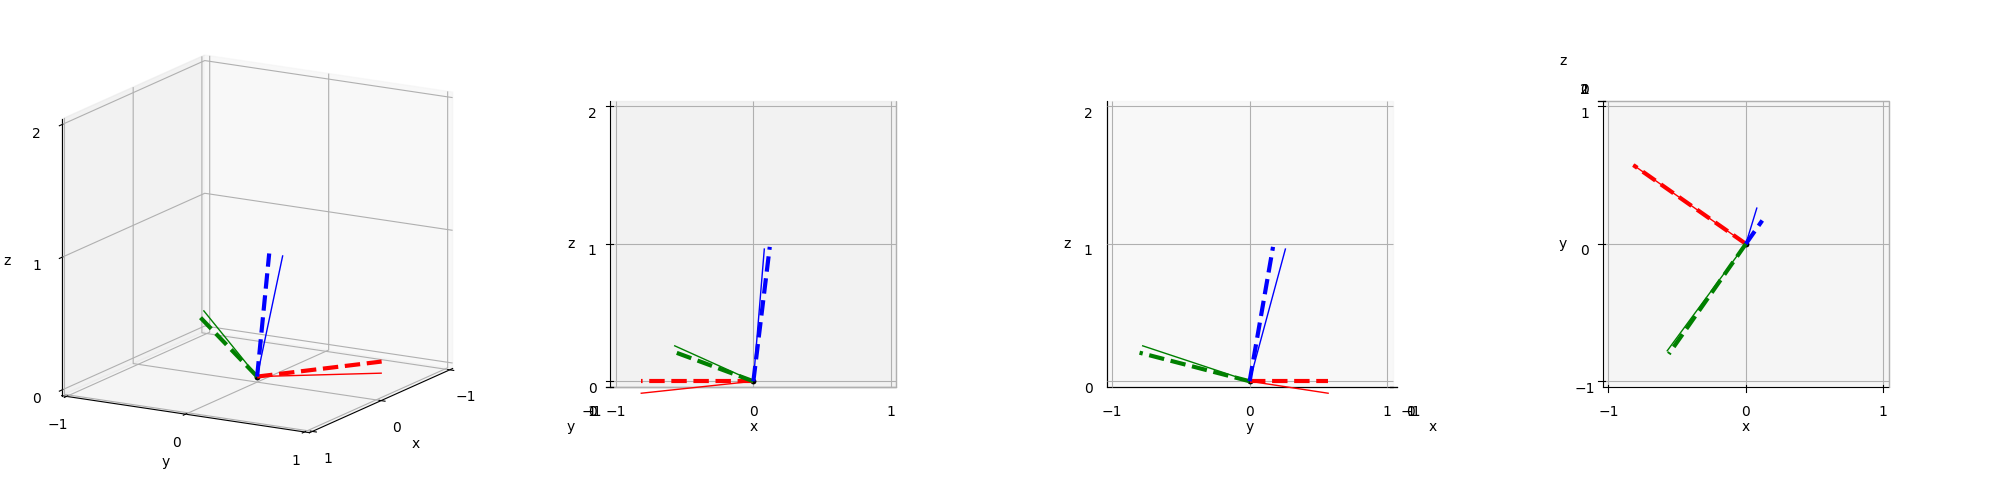

In [338]:
draw_results(T_sta, T_est)
# The solid line is for estimate
# The dashed line is for closest stable pose

### 2 Test pipeline with estimates from real experienment

#### 2.1 Insert Mold

In [339]:
data_all_instances = np.load("./11_23_image_dataset/insertmold.npz", allow_pickle=True)
print("example indeices: ", list(data_all_instances.keys()))

instance1 = data_all_instances['1'].item()
print("keys: ", list(instance1.keys()))

T_part_in_tag = np.array(instance1['T_part_in_tag'])
print("T_part_in_tag: ", T_part_in_tag)

R_part_in_tag = T_part_in_tag[:3, :3]
euler_angles = Rotation.from_matrix(R_part_in_tag).as_euler('xyz', degrees=True)
print("euler_angles: ", euler_angles)

example indeices:  ['0', '1', '2', '3', '4', '5']
keys:  ['class', 'uv', 'score', 'image_128x128', 'T_part_in_cam', 'T_part_in_tag']
T_part_in_tag:  [[ 0.59483074  0.08513523  0.79932996  0.05502507]
 [-0.14684922  0.98915109  0.00392681 -0.09132189]
 [-0.7903238  -0.11971677  0.60087951  0.06494135]
 [ 0.          0.          0.          1.        ]]
euler_angles:  [-11.26783026  52.2157811  -13.86763743]


In [340]:
# these two lists should be element-aligned. 
# e.g. alphas[i] should correspond to z_offsets[i]
alphas_insertmold = np.array([0, 12, -146, 156])
z_offsets_insertmold = np.array([0.0021, 0.0019, 0.0032, 0.0013])

stable_poses_R = construct_R_sta_list(alphas_insertmold)
len(stable_poses_R)

1440

In [341]:
T_est = T_part_in_tag

top3_stable_poses_R = find_top3_stable_poses(stable_poses_R, T_est[:3, :3], isPrint=False)

R_sta = top3_stable_poses_R[0]
alpha_sta = Rotation.from_matrix(R_sta).as_euler('xyz', degrees=True)[0]
index = np.where(alphas_insertmold == int(alpha_sta))[0]
z_offset_sta = z_offsets_insertmold[index]

# Construct transformation matrices
t_sta = np.array([T_est[0,3], T_est[1,3], z_offset_sta], dtype=object)
T_sta = construct_T(R_sta, t_sta)

print("Transformation Matrix for Estimated Pose:")
print(T_est)
print("Euler angles for Estimated Pose:", Rotation.from_matrix(T_est[:3, :3]).as_euler('xyz', degrees=True))
print()
print("Transformation Matrix for Stable Pose:")
print(T_sta)
print("Euler angles for Stable Pose:", Rotation.from_matrix(T_sta[:3, :3]).as_euler('xyz', degrees=True))

print()
print("Angular Difference: ", angular_R_diff(T_est[:3, :3], T_sta[:3, :3]), "degrees")

Transformation Matrix for Estimated Pose:
[[ 0.59483074  0.08513523  0.79932996  0.05502507]
 [-0.14684922  0.98915109  0.00392681 -0.09132189]
 [-0.7903238  -0.11971677  0.60087951  0.06494135]
 [ 0.          0.          0.          1.        ]]
Euler angles for Estimated Pose: [-11.26783026  52.2157811  -13.86763743]

Transformation Matrix for Stable Pose:
[[ 0.99026807  0.1391731   0.          0.05502507]
 [-0.1391731   0.99026807  0.         -0.09132189]
 [ 0.          0.          1.          0.0021    ]
 [ 0.          0.          0.          1.        ]]
Euler angles for Stable Pose: [ 0.  0. -8.]

Angular Difference:  53.068049532301785 degrees


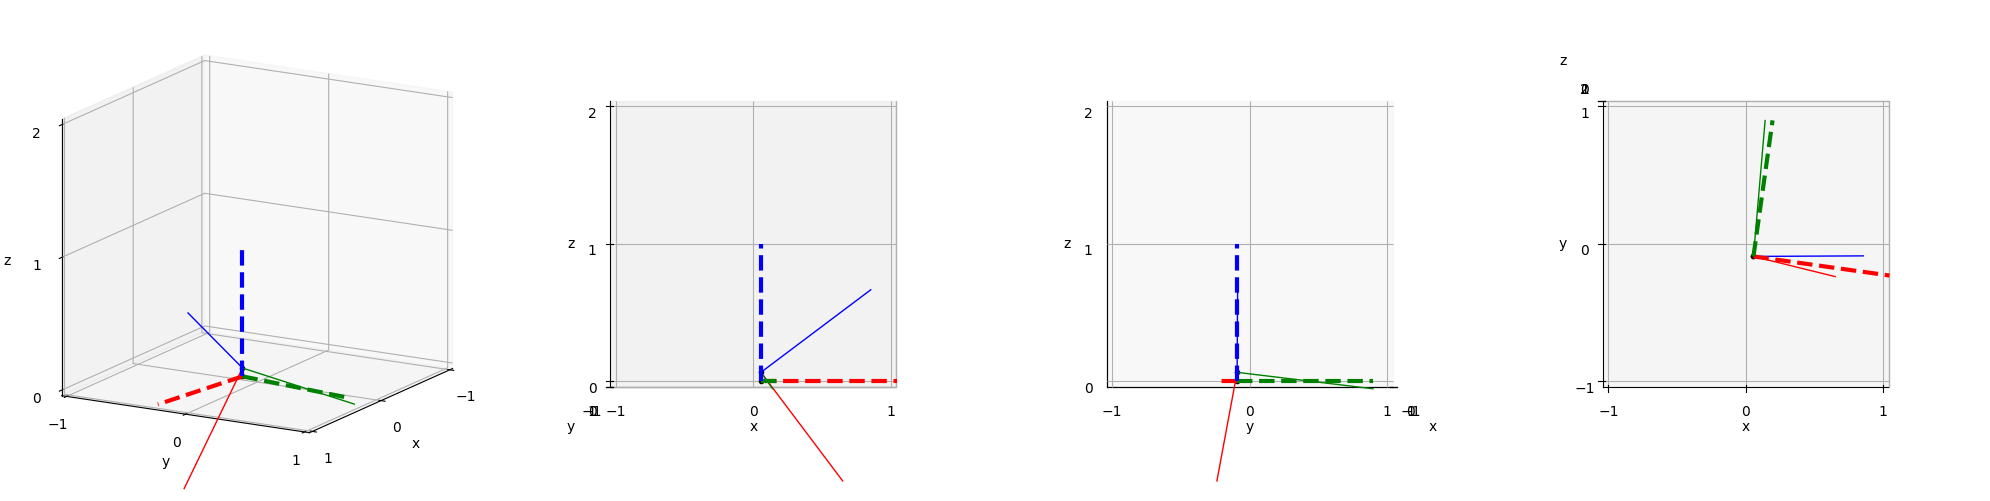

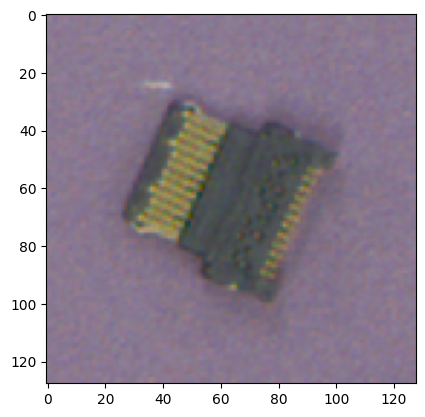

In [342]:
draw_results(T_sta, T_est, s=1)
# The solid line is for estimate
# The dashed line is for closest stable pose

# image with part placed in the tagboard
plt.imshow(instance1['image_128x128'][:,:,::-1])